# Parte I : carga y acceso a la base de datos

### Librerías para acceder a la base de datos

In [1]:
import gdown
import zipfile
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Descargamos el conjunto de imágenes
gdown.download('https://drive.google.com/uc?id=1T5X4pVX_x49nG8_5CSm9_dDj90rvrraF', 'leaf_database.zip')

# Descargamos el archivo csv que contiene las rutas a cada imagen y las etiquetas
gdown.download('https://drive.google.com/uc?id=1WY1AsfhMhk2WbN9OU788y9wms79Vn7g3', 'img_180.zip')

Downloading...
From: https://drive.google.com/uc?id=1T5X4pVX_x49nG8_5CSm9_dDj90rvrraF
To: /content/leaf_database.zip
100%|██████████| 167M/167M [00:00<00:00, 202MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WY1AsfhMhk2WbN9OU788y9wms79Vn7g3
To: /content/img_180.zip
100%|██████████| 134k/134k [00:00<00:00, 87.9MB/s]


'img_180.zip'

In [3]:
## Descomprimimos el .zip que contiene el archivo csv

carpeta_descomprimida = '/content/dataset_datas'

ruta_zip = '/content/img_180.zip'


with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_descomprimida)


archivo_csv = '/content/dataset_datas/img_180.csv'

# Carga el archivo CSV en un DataFrame de pandas
df1= pd.read_csv(archivo_csv)

# Renombramos las columnas de interés
df1 = df1.rename(columns={'fn': 'imagen','ln':'etiqueta'})

df = df1[(df1.iloc[:, 3] >= 7) & (df1.iloc[:, 3] < 13)]

# balanceamos
class_counts = df['etiqueta'].value_counts()

num_muestras_por_clase = class_counts.min()

nuevos_datos = pd.DataFrame()  # DataFrame para almacenar los datos equilibrados

for clase, conteo in class_counts.items():
    if conteo > num_muestras_por_clase:
        # Si hay más ejemplos de los deseados, selecciona una muestra aleatoria para mantener
        subset = df[df['etiqueta'] == clase].sample(num_muestras_por_clase)
    else:
        # Si hay menos ejemplos de los deseados, no cambies nada
        subset = df[df['etiqueta'] == clase]
    nuevos_datos = nuevos_datos.append(subset)

df = nuevos_datos


# Mezcla aleatoriamente el DataFrame
df = df.sample(frac=1, random_state=42)  # random_state para reproducibilidad


# Extraemos las columnas con la dirección de la imagen y la etiqueta para cada una
df_img_ruta = df['imagen']
imagen_etiqueta = df['etiqueta']


# Convertimos el dataframe a numpy para manipularlo más fácil más adelante
df_img_ruta = df_img_ruta.to_numpy()
etiquetas = imagen_etiqueta.to_numpy()

# Organizar la ruta de cada imagen en una lista
df_img = ['/content/dataset_images/leaf_database/' + elemento for elemento in df_img_ruta]

<ipython-input-3-beea8664edb1>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-beea8664edb1>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-beea8664edb1>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-beea8664edb1>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-beea8664edb1>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

In [4]:
etiquetas[0]

7

In [5]:
## Descomprimimos el .zip que contiene las imágenes en la carpeta 'dataset_images'

carpeta_descomprimida = '/content/dataset_images'

ruta_zip = '/content/leaf_database.zip'

with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_descomprimida)


## Creamos una lista que contiene las rutas de todas las imagenes

ruta_imagenes = '/content/dataset_images/leaf_database'
archivos_en_carpeta = os.listdir(ruta_imagenes)

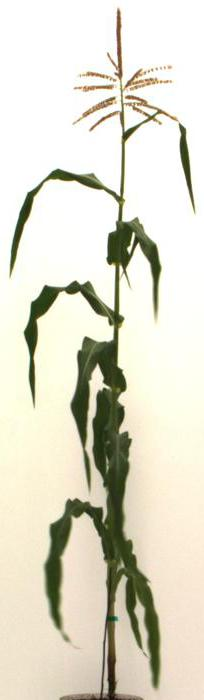

In [6]:
## Accedemos a una imagen aleatoria para comprobar que tenemos acceso

probar_imagen = os.path.join(ruta_imagenes, archivos_en_carpeta[0])

imagen = Image.open(probar_imagen)

display(imagen)

# Parte II preprocesamiento de las imágenes

In [7]:
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 9.6 MB/s eta 0:00:00


In [8]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

### Dividimos el conjunto en subconjuntos para entrenamiento, validación y prueba

In [9]:
train_fraction = int(len(df_img)*0.8) #entrenamos con el 80% de los datos
test_fraction= int(len(df_img)*0.1) #probamos con el 10% de los datos
val_fraction= int(len(df_img)*0.1) #validamos con el 10% de los datos
train_dirs_dataset = tf.data.Dataset.from_tensor_slices((df_img[:train_fraction],etiquetas[:train_fraction]))
test_dirs_dataset = tf.data.Dataset.from_tensor_slices((df_img[train_fraction:(train_fraction+test_fraction)],etiquetas[train_fraction:(train_fraction+test_fraction)]))
val_dirs_dataset=tf.data.Dataset.from_tensor_slices((df_img[(train_fraction+test_fraction):(train_fraction+test_fraction+val_fraction)],etiquetas[(train_fraction+test_fraction):(train_fraction+test_fraction+val_fraction)]))

### Definimos el método que ajusta el tamaño de las imágenes para que puedan ser recibidas por el modelo

In [10]:
def LoadImages(dir_imagen, label_imagen):
    # Leer la imagen JPEG
    img = tf.image.decode_jpeg(tf.io.read_file(dir_imagen), channels=3)
    img = tf.image.resize(img, [224, 224], method=tf.image.ResizeMethod.AREA)
    img = tf.cast(img, dtype=tf.float64) / 255.0  # Escalar al rango [0, 1]
    #img = (img * 2) - 1  # Normalizar entre -1 y 1

    label = tf.cast(label_imagen, dtype=tf.uint8)
    return img, label

In [11]:
train_dataset = train_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = val_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)

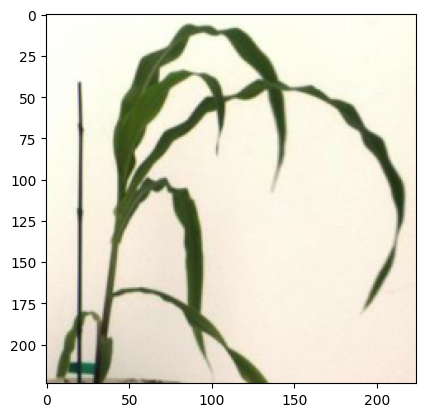

tf.Tensor(8, shape=(), dtype=uint8)


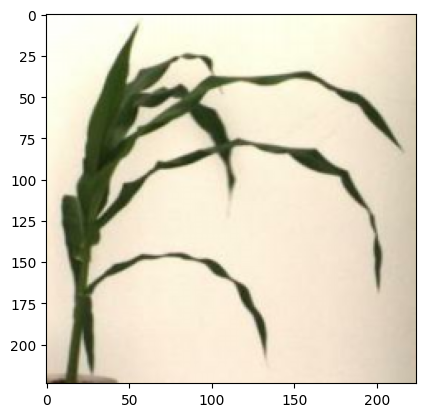

tf.Tensor(7, shape=(), dtype=uint8)


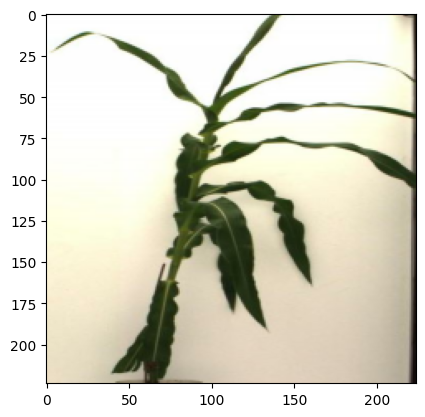

tf.Tensor(12, shape=(), dtype=uint8)


In [12]:
for imagen,label in validation_dataset.take(3):
  plt.imshow((imagen.numpy()))
  plt.show()
  print(label)

In [13]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

# Parte 4 definimos el modelo: usamos transferlearning con el modelo VGG16, además hacemos fine-tuning entrenando las últimas 15 capas de este modelo
Este ejercicio se aborda como un problema de regresión

In [14]:
import numpy as np
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.optimizers import SGD
from tensorflow.keras.metrics import Recall


In [15]:
# Cargar el modelo VGG16 con pesos preentrenados y excluir las capas de clasificación
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar todas las capas excepto las últimas 15
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Crear un modelo secuencial y agregar el modelo base
model = tf.keras.models.Sequential()
model.add(base_model)

# Agregar capas personalizadas para la tarea específica, en este caso la última capa clasifica entre las 6 clase sposibles
# Usamos el parámetro de regularización L2
# Agregar capas personalizadas para la tarea de regresión
model.add(Flatten())
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))

model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.001)))

model.add(Dense(1, activation='linear'))  # Capa de salida para regresión

# Compilar el modelo con la función de pérdida y métricas adecuadas para regresión
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Resumen del modelo
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 15970179 (60.92 MB)
Trainable params: 15931459 (60.77 MB)
Non-trainable params: 38720 (151.25 KB)
___________

In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Definir el callback de parada temprana
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Definir el callback para guardar el mejor modelo
model_checkpoint = ModelCheckpoint('/content/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Definir el callback ReduceLROnPlateau, disminuye el valor del Learning Rate cada vez que la pérdida no mejore cada 3 épocas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

# Combinar todos los callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr]




In [18]:
# Entrenar el modelo con los callbacks
history = model.fit(train_dataset.batch(64),validation_data=validation_dataset.batch(16),epochs=30,callbacks=callbacks)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 3.4588 - mean_absolute_error: 1.2754
Epoch 1: val_loss improved from inf to 1.45753, saving model to /content/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 104s 763ms/step - loss: 3.4588 - mean_absolute_error: 1.2754 - val_loss: 1.4575 - val_mean_absolute_error: 0.9316 - lr: 1.0000e-04
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.2714 - mean_absolute_error: 0.8636
Epoch 2: val_loss improved from 1.45753 to 1.24856, saving model to /content/best_model.h5
92/92 [==============================] - 59s 639ms/step - loss: 1.2714 - mean_absolute_error: 0.8636 - val_loss: 1.2486 - val_mean_absolute_error: 0.8529 - lr: 1.0000e-04
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.1351 - mean_absolute_error: 0.8126
Epoch 3: val_loss improved from 1.24856 to 1.09801, saving model to /content/best_model.h5
92/92 [==============================] - 63s 682ms/step - loss: 1.1351 - mean_absolute_error: 0.8126 - val_loss: 1.0980 - val_mean_absolute_error: 0.8144 - lr: 1.0000e-04
Epoch 4/30
92/92 [==============================] - ETA: 0s - loss: 0.9327 - mean_absolute_err

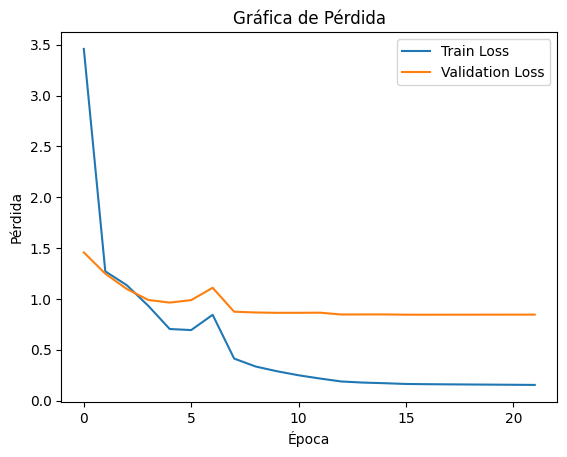

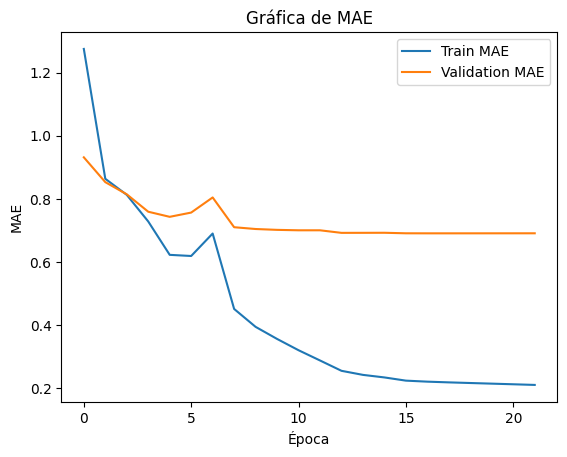

In [20]:
import matplotlib.pyplot as plt

# Gráfica de pérdida (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Gráfica de Pérdida')
plt.show()

# Gráfica de MAE (Mean Absolute Error)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.title('Gráfica de MAE')
plt.show()


In [35]:
# obtenemos las imágenes para el test
test_dataset = test_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64)

# obtenemos las clases reales
true_labels = np.concatenate([labels for _, labels in test_dataset])

# Obtener las predicciones
predictions = model.predict(test_dataset)

# Obtener un iterador de arrays de NumPy desde el conjunto de datos
test_iterator = tf.data.Dataset.as_numpy_iterator(test_dataset)



12/12 [==============================] - 3s 223ms/step


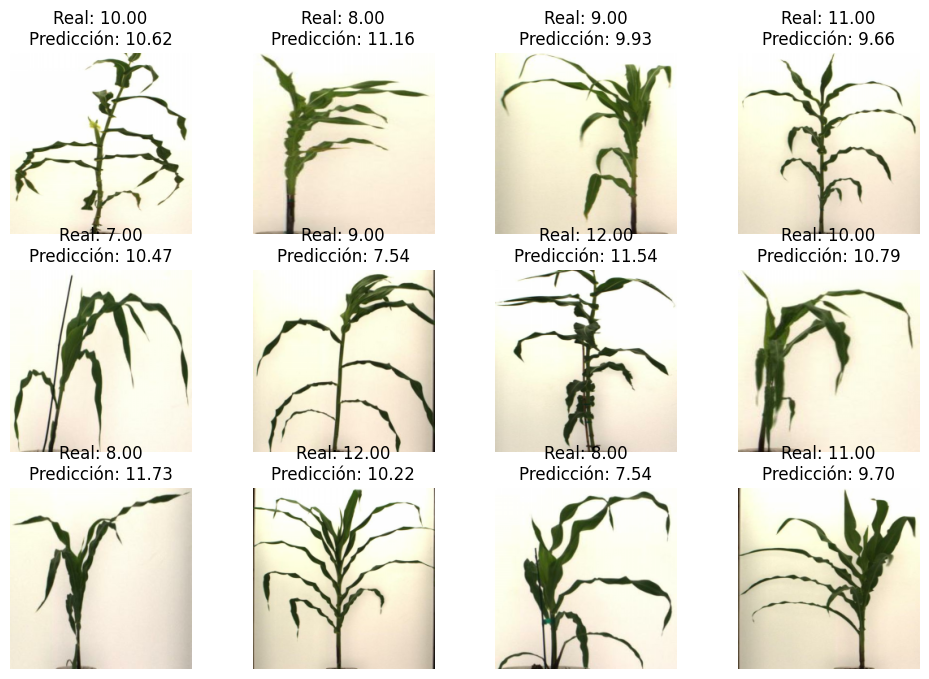

In [36]:
# Graficar los resultados
plt.figure(figsize=(12, 8))

for i, (images, true_labels) in enumerate(test_iterator):
    plt.subplot(3, 4, i + 1)  # Cambia aquí para empezar desde 1
    plt.imshow(images[0])  # Supongamos que queremos visualizar la primera imagen de cada lote
    plt.title(f'Real: {true_labels[0]:.2f}\nPredicción: {predictions[i][0]:.2f}')
    plt.axis('off')

plt.show()

12/12 [==============================] - 3s 222ms/step


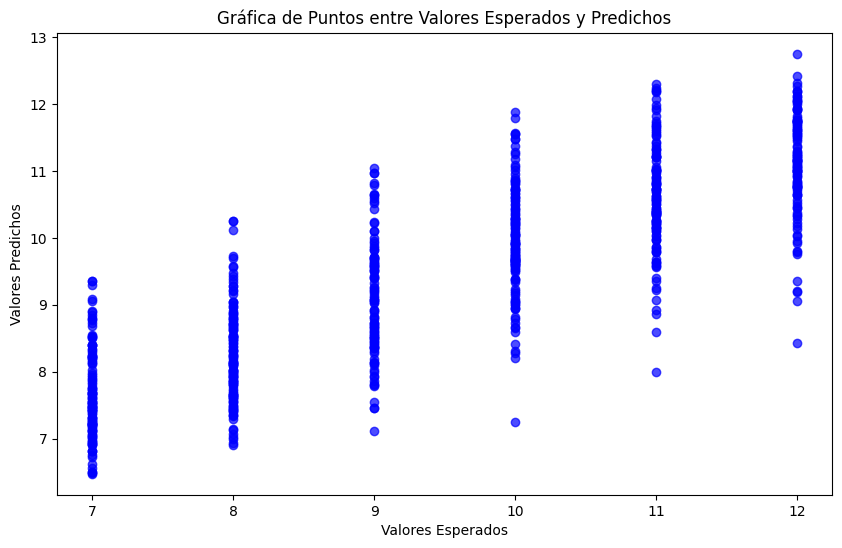

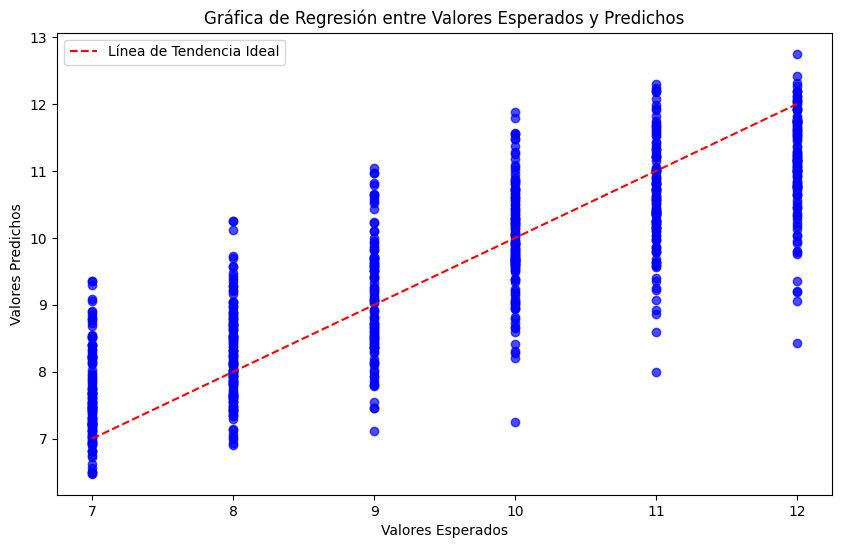

In [44]:
# obtenemos las imágenes para el test
test_dataset = test_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64)

# obtenemos las clases reales
true_labels = np.concatenate([labels for _, labels in test_dataset])

# Obtener las predicciones
predictions = model.predict(test_dataset)

# Crear gráfica de puntos
y_true= true_labels
plt.figure(figsize=(10, 6))
plt.scatter(y_true, predictions, color='blue', alpha=0.7)
plt.title('Gráfica de Puntos entre Valores Esperados y Predichos')
plt.xlabel('Valores Esperados')
plt.ylabel('Valores Predichos')
plt.show()

# Crear gráfica de regresión (línea de tendencia)
plt.figure(figsize=(10, 6))
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', label='Línea de Tendencia Ideal')
plt.scatter(y_true, predictions, color='blue', alpha=0.7)
plt.title('Gráfica de Regresión entre Valores Esperados y Predichos')
plt.xlabel('Valores Esperados')
plt.ylabel('Valores Predichos')
plt.legend()
plt.show()
